In [1]:
using Pkg
Pkg.add("IJulia")
Pkg.add("ITensors")
Pkg.add("ITensorMPS")
Pkg.add("LinearAlgebra")
Pkg.add("Random")
Pkg.add("Plots")

┌ Error: curl_easy_setopt: 4
└ @ Downloads.Curl C:\Users\Leonardo.Borello\AppData\Local\Programs\Julia-1.11.4\share\julia\stdlib\v1.11\Downloads\src\Curl\utils.jl:50
    Updating registry at `C:\Users\Leonardo.Borello\.julia\registries\General.toml`
┌ Error: curl_easy_setopt: 4
└ @ Downloads.Curl C:\Users\Leonardo.Borello\AppData\Local\Programs\Julia-1.11.4\share\julia\stdlib\v1.11\Downloads\src\Curl\utils.jl:50
   Resolving package versions...
  No Changes to `C:\Users\Leonardo.Borello\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Leonardo.Borello\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
┌ Error: Failed to write valid usage file `C:\Users\Leonardo.Borello\.julia\logs\artifact_usage.toml`
│   tempfile = "C:\\Users\\LEONAR~1.BOR\\AppData\\Local\\Temp\\jl_IDI3yt4tep"
└ @ Pkg.Types C:\Users\Leonardo.Borello\AppData\Local\Programs\Julia-1.11.4\share\julia\stdlib\v1.11\Pkg\src\Types.jl:571
  No Changes to `C:\Users\Leonardo.Borello\.julia

In [7]:
using ITensors, ITensorMPS, LinearAlgebra

#product_state = MPS(sites, "Up")

function generate_mps(N::Int, h::Float64, J::Float64, nsweeps::Int, cutoff::Vector{Float64})
    # Create a site set for spin-1/2
    sites = siteinds("S=1/2", N)
    
    # (Optional) Create a simple product state, if needed elsewhere.
    product_state = MPS(sites, "Up")
    
    # Build the Hamiltonian as an MPO using an OpSum
    os = OpSum()
    for j in 1:N-1
        os += J, "Sz", j, "Sz", j+1
    end
    for j in 1:N
        os += h, "Sx", j
    end
    H = MPO(os, sites)
    
    # Initialize a random MPS (here, using "Dn" as a starting state)
    psi0 = random_mps(sites, n -> "Dn")
    
    # Run DMRG to obtain a ground state approximation.
    energy, psi1 = dmrg(H, psi0; nsweeps=nsweeps, cutoff=cutoff)
    
    # Bring the resulting MPS into a left-canonical form.
    psi_non_truncated = orthogonalize!(psi1, 1)
    
    return psi_non_truncated
end

# Parameters
N = 10
h = 0.5
J = 1.0
nsweeps = 5
cutoff = [1e-10]

# Example usage:
psi_non_truncated = generate_mps(N, h, J, nsweeps, cutoff)
sites = siteinds(psi_non_truncated)
product_state = MPS(sites, "Up")


After sweep 1 energy=-3.0932350287182486  maxlinkdim=4 maxerr=2.76E-16 time=8.906
After sweep 2 energy=-3.095372441690607  maxlinkdim=9 maxerr=8.05E-11 time=0.008
After sweep 3 energy=-3.0953724990848595  maxlinkdim=8 maxerr=9.38E-11 time=0.011
After sweep 4 energy=-3.095372499162341  maxlinkdim=8 maxerr=7.01E-11 time=0.028
After sweep 5 energy=-3.0953724991562037  maxlinkdim=8 maxerr=7.00E-11 time=0.010


MPS
[1] ((dim=2|id=869|"S=1/2,Site,n=1"), (dim=1|id=209|"Link,l=1"))
[2] ((dim=1|id=209|"Link,l=1"), (dim=2|id=783|"S=1/2,Site,n=2"), (dim=1|id=406|"Link,l=2"))
[3] ((dim=1|id=406|"Link,l=2"), (dim=2|id=709|"S=1/2,Site,n=3"), (dim=1|id=118|"Link,l=3"))
[4] ((dim=1|id=118|"Link,l=3"), (dim=2|id=279|"S=1/2,Site,n=4"), (dim=1|id=292|"Link,l=4"))
[5] ((dim=1|id=292|"Link,l=4"), (dim=2|id=168|"S=1/2,Site,n=5"), (dim=1|id=892|"Link,l=5"))
[6] ((dim=1|id=892|"Link,l=5"), (dim=2|id=164|"S=1/2,Site,n=6"), (dim=1|id=593|"Link,l=6"))
[7] ((dim=1|id=593|"Link,l=6"), (dim=2|id=0|"S=1/2,Site,n=7"), (dim=1|id=164|"Link,l=7"))
[8] ((dim=1|id=164|"Link,l=7"), (dim=2|id=533|"S=1/2,Site,n=8"), (dim=1|id=509|"Link,l=8"))
[9] ((dim=1|id=509|"Link,l=8"), (dim=2|id=313|"S=1/2,Site,n=9"), (dim=1|id=489|"Link,l=9"))
[10] ((dim=1|id=489|"Link,l=9"), (dim=2|id=368|"S=1/2,Site,n=10"))


In [14]:
# function to generate MPDs


function generate_mpds(psi)
    N = length(psi)
    psi = copy(psi)
    mpds = Dict{Int, ITensor}()
    
    for n = 1
        i = inds(psi[n], "Site")[1]
        j = commoninds(psi[n], psi[n+1])[1]
        
        Array_tensor1 = Array(psi[n], i,j)

        T = zeros(2,2,2,2)
        T[:,:,1,1] = Array_tensor1

        i2,j2,k2,l2 = prime(siteinds(psi, n)), prime(siteinds(psi, n+1)), siteinds(psi, n), siteinds(psi, n+1)
        tensor = ITensor(T, i2,j2,k2,l2)
        U,S,V = svd(tensor, i2,j2)

        S1 = delta(commonind(U,S), commonind(S,V))
        
        mpds[n] = U * S1 * V  
    end

    for n in 2:N-1
        i = inds(psi[n], "Site")[1]
        j = commoninds(psi[n], psi[n+1])[1]
        k = commoninds(psi[n-1], psi[n])[1]

                Array_tensor2 = Array(psi[n], i,j,k)

        G = zeros(2,2,2,2)
        G[:,:,:,1] = Array_tensor2 

        i2,j2,k2,l2 = prime(siteinds(psi, n)), prime(siteinds(psi, n+1)), siteinds(psi, n), siteinds(psi, n+1)
        tensor = ITensor(G, i2,j2,k2,l2)

        U,S,V = svd(tensor, i2,j2)
        S1 = delta(commonind(U,S), commonind(S,V))
        
        mpds[n] = U * S1 * V
    end

    for n = N
        i = inds((psi[n]), "Site")[1]
        j = commoninds(psi[n-1], psi[n])[1]
        mpds[n] = replaceinds(psi[n], i => prime(i), j => inds((psi[n]), "Site")[1])
    end
    return mpds
end

#This function helps with turning U into dag(U), and reverses the order such that we can apply to the MPS and disentangle it

function dagger!(mpds)
    mpds_dag = [dag(t) for t in mpds]
    for t in mpds_dag
        swapprime!(t, 0=>1)
    end
    return reverse(mpds_dag)
end

# Generate a circuit of depth D, with corresponding MPD gates.

function deep!(psi_non_truncated, D)
    N = length(sites)
    circuit_layers = Vector{Vector{ITensor}}(undef, D)
    
    psi_current = copy(psi_non_truncated)
    for d in 1:D
        psi_trunc = truncate(psi_current, maxdim=2)
        mpds = generate_mpds(psi_trunc)
        ordered_keys = sort(collect(keys(mpds)))
        mpds_vec = [mpds[n] for n in ordered_keys]
        mpds_vec = dagger!(mpds_vec)

        
        circuit_layers[d] = mpds_vec
        # Apply the MPDs to psi_current to get the next state
        psi_current = apply(mpds_vec, psi_current)
    end
    
    return circuit_layers
end



# Once we have generated a circuit from the initial MPS, we reverse the depth and order of contraction, as well as switch the 
# primes of the indices. This prepares the MPDs to entangle the product state.
# We use the function reverse_circuit:

function reverse_deep!(circuit_layers::Vector{Vector{ITensor}})
    reversed_circuit = Vector{Vector{ITensor}}(undef, length(circuit_layers))
    
    for (i, layer) in enumerate(reverse(circuit_layers))
        reversed_layer = Vector{ITensor}(undef, length(layer))
        for (j, tensor) in enumerate(reverse(layer))
            reversed_layer[j] = swapprime(dag(tensor), 0=>1)
        end
        reversed_circuit[i] = reversed_layer
    end
    
    return reversed_circuit
end

# Once we reverse the circuit, we can contract it with the product state like we usually would, using apply reverse cirucit:

function reverse_attract!(reversed_circuit, product_state)
    D = length(reversed_circuit)
    state = copy(product_state)
    
    for d in 1:D
        state = apply(reversed_circuit[d], state)
    end
    return state
end



# Generating the QMPS

#Parameters
D = 4


# Example usage:
psi_non_truncated = copy(psi_non_truncated)
product_state = copy(product_state)

# Now call the deep! function with the product state.
circuit_layers = deep!(psi_non_truncated, D)
reversed_circuit = reverse_deep!(circuit_layers)
state = reverse_attract!(reversed_circuit, product_state)
overlap = abs(inner(state, psi_non_truncated))

0.0015433919608627278

In [11]:
#Ansatz MPS
psi_non_truncated = copy(psi_non_truncated)
product_state = copy(product_state)
circuit_layers = copy(circuit_layers)
reversed_circuit = copy(reversed_circuit)

function Ansatz_target(reversed_circuit, product_state)
    N = length(reversed_circuit)
    Ansatz_MPS = product_state

    for n = 1
        Ansatz_MPS = apply(reversed_circuit[n], Ansatz_MPS, maxdim = 2)
    end
    return Ansatz_MPS

end

Ansatz_MPS = Ansatz_target(reversed_circuit, product_state)
#Ansatz_MPs = orthogonalize(Ansatz_MPS, 1)

#Target state
function target!(circuit_layers, psi_non_truncated)
    N = length(circuit_layers)
    target_state = psi_non_truncated
    for n in 1:N-1
        target_state = apply(circuit_layers[n], target_state)
    end
    
    maxbond = maximum(linkdims(psi_non_truncated))
    target_state = truncate(target_state, maxdim = maxbond)

    return target_state
end

# Global error computation
function compute_global_error(target_state, Ansatz_MPS)
    overlap = inner(target_state, Ansatz_MPS)
    return abs(1 - abs(overlap)^2)
end

target_state = target!(circuit_layers, psi_non_truncated)


compute_global_error(target_state, Ansatz_MPS)


0.0015522685517442847

In [12]:
function left!(target_state, Ansatz_MPS)
    N = length(target_state)
    Lenv = Vector{ITensor}(undef, N)
    Lenv[1] = ITensor(1.0)
    
    for site in 1:N-1
        Lenv[site+1] = Lenv[site] * (dag(target_state[site]) * Ansatz_MPS[site])
    end
    return Lenv
end
    
        
function right!(target_state, Ansatz_MPS)
    N = length(target_state)
    Renv = Vector{ITensor}(undef, N)
    Renv[N] = ITensor(1.0)

    for site in reverse(2:N)
        Renv[site-1] = Renv[site] * (dag(target_state[site]) * Ansatz_MPS[site])
    end
    return Renv
end


right! (generic function with 1 method)

Starting sweep 1
Completed sweep 1 with global error: 0.0015394516542642789
Starting sweep 2
Completed sweep 2 with global error: 0.0015174061625841118
Starting sweep 3
Completed sweep 3 with global error: 0.0015067096420912085
Starting sweep 4
Completed sweep 4 with global error: 0.001505690648328284
Starting sweep 5
Completed sweep 5 with global error: 0.0015051296646523271
Starting sweep 6
Completed sweep 6 with global error: 0.001504711406642878
Starting sweep 7
Completed sweep 7 with global error: 0.0015043763187166936
Starting sweep 8
Completed sweep 8 with global error: 0.0015040978643166003
Starting sweep 9
Completed sweep 9 with global error: 0.0015038642818722137
Starting sweep 10
Completed sweep 10 with global error: 0.0015036691914599443
Starting sweep 11
Completed sweep 11 with global error: 0.001503507521716796
Starting sweep 12
Completed sweep 12 with global error: 0.0015033745684649436
Starting sweep 13
Completed sweep 13 with global error: 0.0015032659308827911
Startin

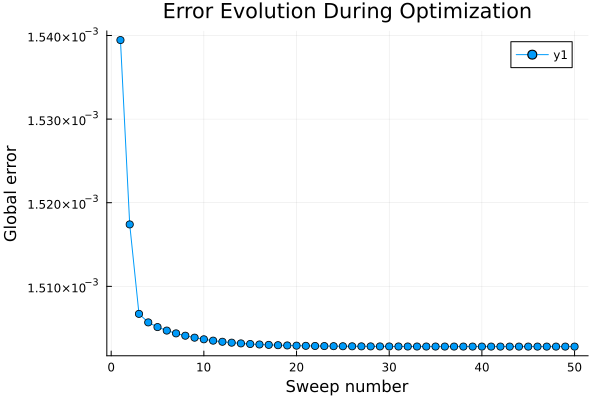

In [13]:
function optimize!(target_state, Ansatz_MPS; max_sweeps = 10)
    N = length(Ansatz_MPS)
    errors = Float64[]
    
    # Perform a series of sweeps over the system
    for sweep in 1:max_sweeps
        println("Starting sweep $sweep")
        # Recompute right environments based on the current Ansatz_MPS
        Renv = right!(target_state, Ansatz_MPS)
        
        # Initialize the left environment (starting with an identity-like ITensor)
        Lenv = ITensor(1.0)
        
        # Left-to-right sweep: update sites 1 to N
        for s in 1:N
            # Construct the updated tensor using the left environment, target state, and right environment
            M = Lenv * target_state[s] * Renv[s]
            Ansatz_MPS[s] = M

            if s == 1
                i = inds(Ansatz_MPS[s], "Site")[1]
                Q, R = qr(Ansatz_MPS[s], i)
                Ansatz_MPS[s] = Q
                
                # Absorb the R factor into the next site and normalize
                Ansatz_MPS[s+1] *= R
                Ansatz_MPS[s+1] /= norm(Ansatz_MPS[s+1])

            elseif s < N
                i = commoninds(Ansatz_MPS[s-1], Ansatz_MPS[s])[1]
                j = inds(Ansatz_MPS[s], "Site")[1]
                Q, R = qr(Ansatz_MPS[s], (i,j))
                Ansatz_MPS[s] = Q
                
                Ansatz_MPS[s+1] *= R
                Ansatz_MPS[s+1] /= norm(Ansatz_MPS[s+1])   
            else  # s == N
                i = inds(Ansatz_MPS[N], "Site")[1]
                Q, R = qr(Ansatz_MPS[N], i)
                Ansatz_MPS[s] = Q
                Ansatz_MPS[s-1] *= R  # Update the previous site tensor
                Ansatz_MPS[s-1] /= norm(Ansatz_MPS[s-1]) 
            end
            # Update the left environment for the next site update
            Lenv = Lenv * (dag(target_state[s]) * Ansatz_MPS[s])
        end

        # Compute and log the global error for the current sweep
        global_error = compute_global_error(target_state, Ansatz_MPS)
        push!(errors, global_error)
        println("Completed sweep $sweep with global error: $global_error")
    end
    
    return Ansatz_MPS, errors
end


max_sweeps = 50
optimized_Ansatz, error_evolution = optimize!(target_state, Ansatz_MPS; max_sweeps=max_sweeps)

using Plots
p = plot(error_evolution,
     xlabel="Sweep number",
     ylabel="Global error",
     title="Error Evolution During Optimization",
     marker=:circle)
@show p

#savefig(p, "Optimised_plot.png")